## RegNet Training

Due to this being the last day before the end of the competition, this hail mary attempt is our last option to beat our 0.77 score.

The idea: 
- ensure all classes are represented equally --> didn't learn, so simply make the imbalances less severe
- compose features like: melspec on 5s audios, mfcc from reverted 5s melspec, concatted together --> didn't learn at all, so choosing melspec + melspec of reversed audio --> didn't learn, so back to melspec + mfcc as 2 channels

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import regnet_y_800mf, RegNet_Y_800MF_Weights
from torchvision import transforms as T_Vision
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F
from torchaudio import functional as F_audio
from tqdm import tqdm
import torchaudio
import torchaudio.transforms as T_audio

import copy
import random
import glob
import os
import time
import sys
import re

In [2]:
RANDOM_SEED = 11

# Set seed for experiment reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
## REUSE IN INFERENCE NOTEBOOK

custom_dataset_path = '/kaggle/input/birdclef2023-inference'
if os.path.exists(os.path.join(custom_dataset_path, 'utils.py')):
    sys.path.append(custom_dataset_path)
else:
    sys.path.append('..')
import utils

IS_IN_KAGGLE_ENV = utils.get_is_in_kaggle_env()

DATA_PATH = '/kaggle/input/birdclef-2023' if IS_IN_KAGGLE_ENV else '../data'
JOBLIB_PATH = custom_dataset_path if IS_IN_KAGGLE_ENV else './'

DEVICE = 'cpu' if IS_IN_KAGGLE_ENV else utils.determine_device()

AUDIO_LENGTH_S = 5
SAMPLE_RATE = 32_000

We are running code on Localhost
We are using device: mps


In [4]:
if not IS_IN_KAGGLE_ENV and not os.path.exists(DATA_PATH):
    print("Downloading data ...")
    !kaggle competitions download -c 'birdclef-2023'
    !mkdir ../data
    !unzip -q birdclef-2023.zip -d ../data
    !rm birdclef-2023.zip

DF_METADATA_CSV = pd.read_csv(f"{DATA_PATH}/train_metadata.csv")

AUDIO_DATA_DIR = f"{DATA_PATH}/train_audio/"

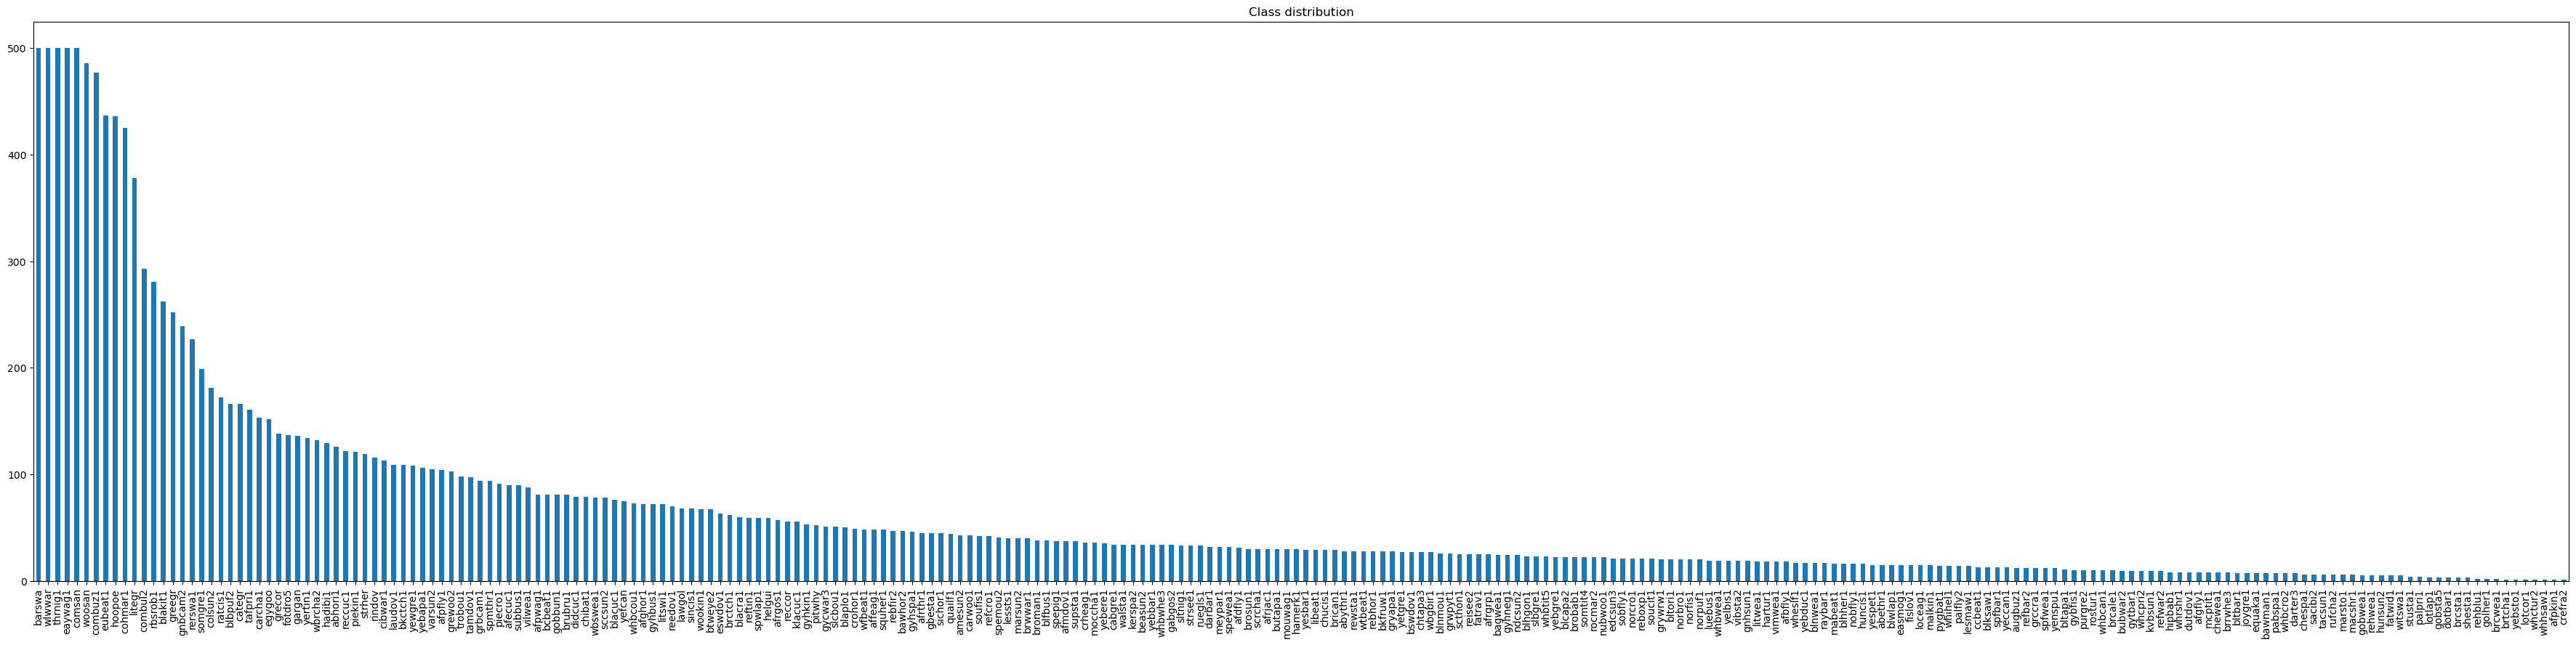

Number of rows before dropping: 16941
Number of rows after dropping: 8898


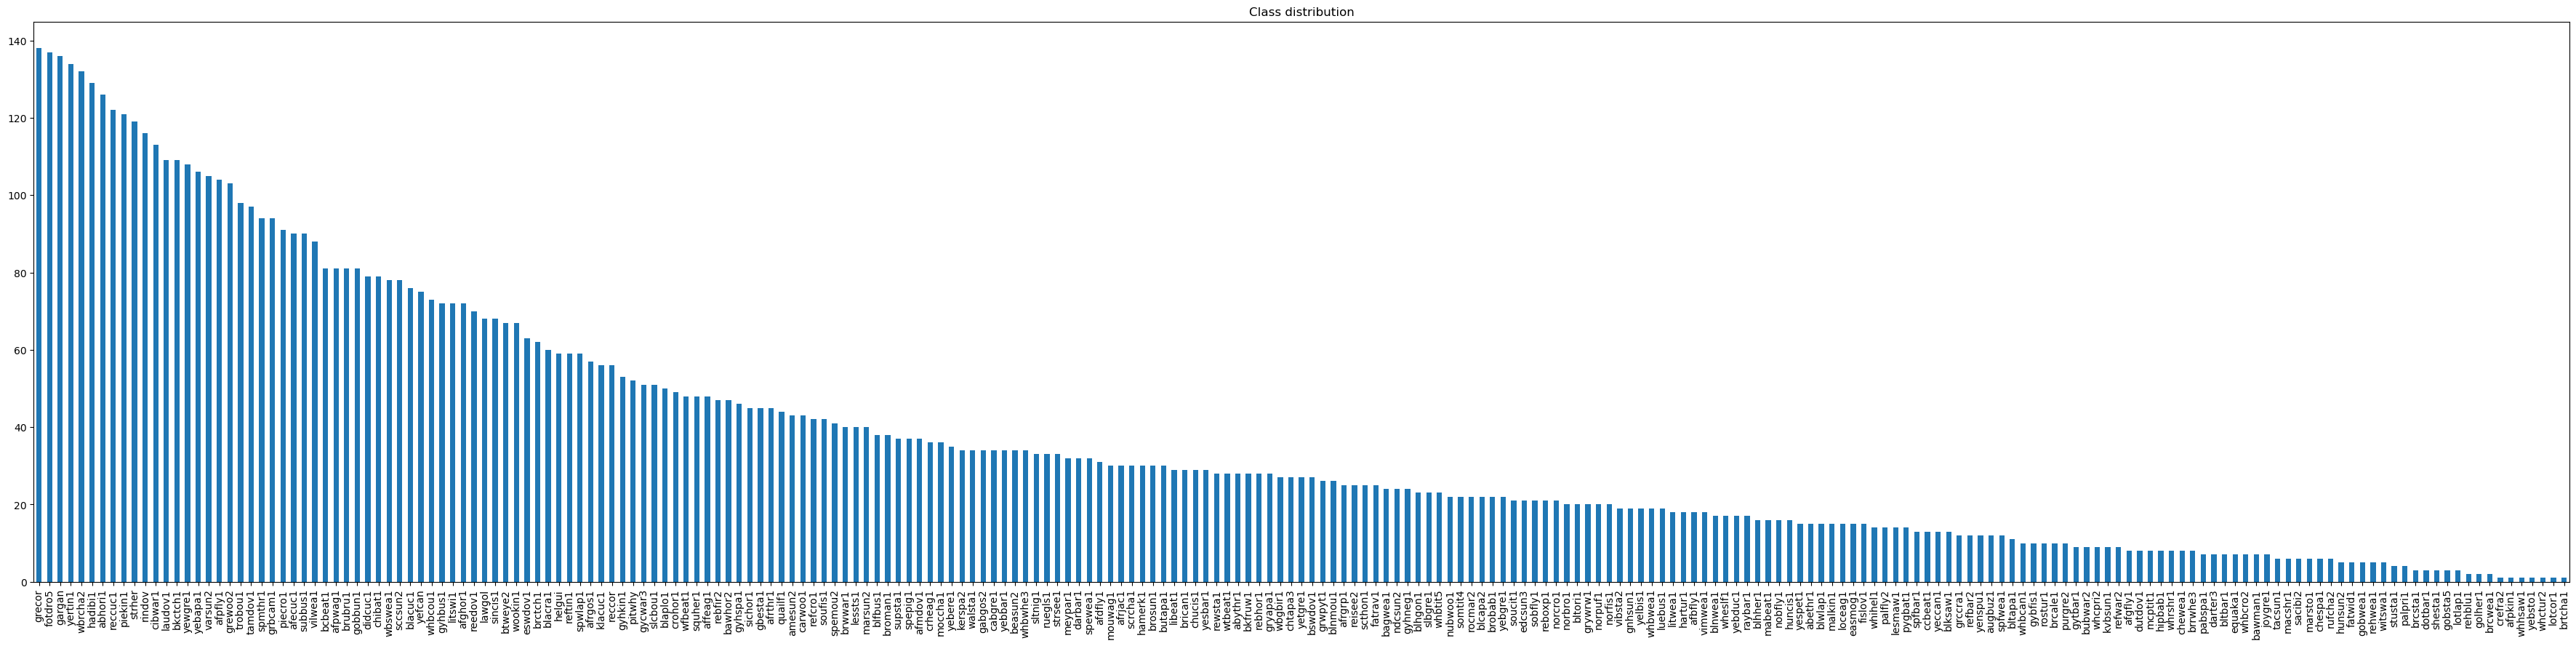

Number of rows before copying: 8898
Number of rows after copying: 10956


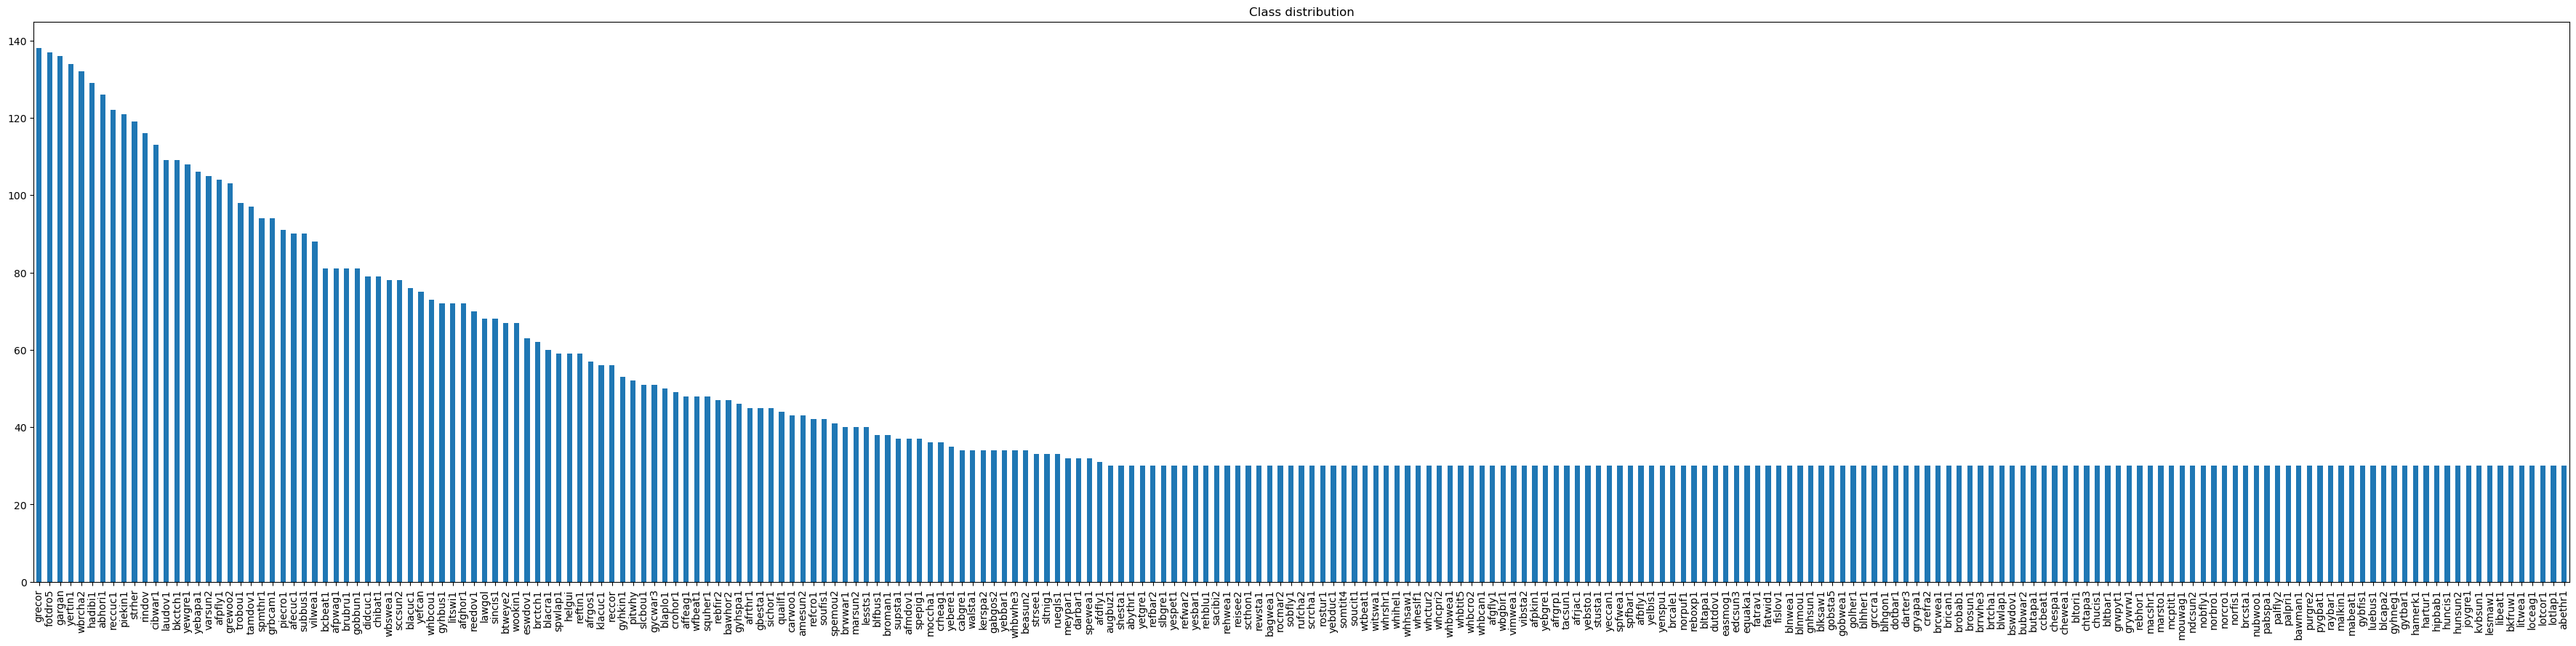

In [5]:
# Function to plot the class distribution
def plot_class_distribution(df, title="Class distribution", figsize=(45, 10)):
    class_counts = df["primary_label"].value_counts()
    plt.figure(figsize=figsize)
    plt.title(title)
    class_counts.plot(kind='bar')
    plt.show()

plot_class_distribution(DF_METADATA_CSV)

class_counts = DF_METADATA_CSV["primary_label"].value_counts()

# Drop rows with primary_label that have 150 or more samples
print(f"Number of rows before dropping: {len(DF_METADATA_CSV)}")
DF_METADATA_CSV = DF_METADATA_CSV[~DF_METADATA_CSV["primary_label"].isin(class_counts[class_counts >= 150].index)]
print(f"Number of rows after dropping: {len(DF_METADATA_CSV)}")
plot_class_distribution(DF_METADATA_CSV)

# Copy rows with primary_label that have 29 or less samples, until they have 30 samples
print(f"Number of rows before copying: {len(DF_METADATA_CSV)}")
for class_name in class_counts[class_counts <= 29].index:
    class_df = DF_METADATA_CSV[DF_METADATA_CSV["primary_label"] == class_name]
    class_df = class_df.sample(n=30 - len(class_df), replace=True)
    DF_METADATA_CSV = pd.concat([DF_METADATA_CSV, class_df])
print(f"Number of rows after copying: {len(DF_METADATA_CSV)}")

plot_class_distribution(DF_METADATA_CSV)

In [6]:
## REUSE IN INFERENCE NOTEBOOK

class BirdMelspecClf(nn.Module):
    def __init__(self, out_features, pretrained):
        super().__init__()
        
        # https://pytorch.org/vision/stable/models.html

        self.regnet = regnet_y_800mf(weights=RegNet_Y_800MF_Weights.DEFAULT) if pretrained else regnet_y_800mf()

        """
        Replace the stem to take 2 channels instead of 3. The original stem:
        RegnetCNN(
        (regnet): RegNet(
            (stem): SimpleStemIN(
            (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
        )"""
        self.regnet.stem = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )
        
        # Replace original classifier: (fc): Linear(in_features=784, out_features=1000, bias=True)
        self.regnet.fc = nn.Linear(self.regnet.fc.in_features, out_features)

        self.softmax = nn.Softmax(dim=1)
 
    def forward(self, x):
        logits = self.regnet(x)
        probas = self.softmax(logits)

        return logits, probas


def get_model(out_features, device, pretrained=False, load_state_dict=True, state_dict_starts_with=f"{AUDIO_LENGTH_S}s_regnetY800MF_hailmary"):
    model = BirdMelspecClf(out_features=out_features, pretrained=pretrained)
    print(f"Loaded model {model.__class__.__name__} with {sum(p.numel() for p in model.parameters())} parameters, pretained={pretrained}")
    model.to(device)

    if not load_state_dict:
        return model

    model_files = [f for f in os.listdir(JOBLIB_PATH) if f.startswith(state_dict_starts_with) and f.endswith('.pt')]
    if len(model_files) == 0:
        print(f"No model starting with {state_dict_starts_with} found in {JOBLIB_PATH}")
        return model
    
    # Extract timestamp from the filenames and sort based on it
    model_files.sort(key=lambda x: int(re.findall(r'\d+', x)[-1]) if re.findall(r'\d+', x) else -1)

    # The latest model file is the last one in the sorted list
    latest_model_file = model_files[-1]
    model_path = os.path.join(JOBLIB_PATH, latest_model_file)
    model.load_state_dict(torch.load(model_path))
    print(f"Loaded model weights from {model_path}")
    model.to(device)

    return model

In [7]:
UNIQUE_CLASSES = DF_METADATA_CSV.primary_label.unique()
N_CLASSES = len(UNIQUE_CLASSES)
print(f"Number of classes: {N_CLASSES}")

Number of classes: 239


In [8]:
train_classes_paths = glob.glob(f"{DATA_PATH}/train_audio/*")
len(train_classes_paths), train_classes_paths[0]

(264, '../data/train_audio/ruegls1')

In [9]:
print(f"Total samples in dataset: {len(DF_METADATA_CSV)}")

Total samples in dataset: 10956


In [10]:
class_with_fewest_samples = DF_METADATA_CSV.primary_label.value_counts(sort=True).index[-1]
print(f"Class with fewest samples: {class_with_fewest_samples}: {DF_METADATA_CSV.primary_label.value_counts().min()} samples")

Class with fewest samples: abethr1: 30 samples


In [11]:
## REUSE IN INFERENCE NOTEBOOK

def resample(audio, current_sample_rate, desired_sample_rate=SAMPLE_RATE):
    resampler = torchaudio.transforms.Resample(orig_freq=current_sample_rate, new_freq=desired_sample_rate)
    resampled_audio = resampler(audio)
    return resampled_audio

def load_audio(audio_path, sample_rate=SAMPLE_RATE):
    audio, sr = torchaudio.load(audio_path)
    if sr != sample_rate:
        audio = resample(audio, sr, sample_rate)
    return audio

# Using librosa defaults for n_fft and hop_length
def get_melspec_transform(sample_rate=SAMPLE_RATE, n_fft=2048, hop_length=512, n_mels=128):
    return torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
    )

# Using librosa defaults for top_db
def get_melspec_db_transform(stype='power', top_db=80):
    return torchaudio.transforms.AmplitudeToDB(
        stype=stype,
        top_db=top_db
    )

# Copied from torchaudio/transforms/_transforms.py (to avoid converting to melspec twice)
dct_mat = F_audio.create_dct(128, 128, "ortho")
def get_mfcc_from_melspec(melspec):
    return torch.matmul(melspec.transpose(-1, -2), dct_mat).transpose(-1, -2)

def normalize_tensor(tensor):
    min_val = torch.min(tensor)
    max_val = torch.max(tensor)
    if max_val - min_val == 0:
        return tensor
    else:
        return (tensor - min_val) / (max_val - min_val)

In [15]:
class BirdClef23Dataset(Dataset):
    def __init__(self, df, audio_data_dir, label_encoder, n_mels, device, pad_method='wrap', transforms=None):
        self.df = df
        self.audio_data_dir = audio_data_dir
        self.label_encoder = label_encoder
        self.device = device
        self.pad_method = pad_method
        self.melspec_transform = get_melspec_transform(n_mels=n_mels)
        self.melspec_db_transform = get_melspec_db_transform()
        self.transforms = transforms
        self.reshape_transform = T_Vision.Resize((64, 313), antialias=True)

    def __getitem__(self, index):
        audio_path = os.path.join(self.audio_data_dir, self.df.iloc[index, 11])
        audio = load_audio(audio_path, SAMPLE_RATE)

        # Increase audio length if below {AUDIO_LENGTH_S} by padding
        if audio.shape[1] < AUDIO_LENGTH_S * SAMPLE_RATE:
            padding_needed = AUDIO_LENGTH_S * SAMPLE_RATE - audio.shape[1]

            if self.pad_method == 'wrap':
                audio = F.pad(audio, (0, padding_needed), mode='replicate')

            elif self.pad_method == 'zeros':
                audio = F.pad(audio, (0, padding_needed), mode='constant', value=0)

        # Truncate audio length if above {AUDIO_LENGTH_S} by random cropping
        if audio.shape[1] > AUDIO_LENGTH_S * SAMPLE_RATE:
            max_start_idx = audio.shape[1] - (SAMPLE_RATE * AUDIO_LENGTH_S)
            start_idx = torch.randint(0, max_start_idx, (1,)).item()
            audio = audio[:, start_idx:start_idx + (SAMPLE_RATE * AUDIO_LENGTH_S)]

        melspec = self.melspec_db_transform(self.melspec_transform(audio))
        norm_melspec = normalize_tensor(melspec) # (1, 128, 313)

        mfcc = get_mfcc_from_melspec(melspec)
        norm_mfcc = normalize_tensor(mfcc) # (1, 128, 313)

        features = torch.cat((norm_melspec, norm_mfcc), dim=0) # (2, 128, 313)

        if self.transforms:
            features = self.transforms(features)
        
        primary_label_raw = self.df.iloc[index, 0]
        primary_label = self.label_encoder.transform([primary_label_raw])[0]

        return features, primary_label

    def __len__(self):
        return len(self.df)


def get_data_loader(dataset, batch_size=32, data_percentage=None, shuffle=False, pin_memory=False):
    if data_percentage is not None:
        data_len = int(len(dataset) * data_percentage)
        dataset, _ = random_split(dataset, [data_len, len(dataset) - data_len])

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)

    return data_loader


def split_df(df, primary_label='primary_label', percentages=[60, 20, 20]):
    """
    - Percentages: [train, valid, test]
    - Splits a dataframe into three dataframes (train, valid, test), stratified by primary_label
    - Also returns the class weights (based on the training set)
    """
    print(f"Splitting dataframe into train {percentages[0]}%, valid {percentages[1]}%, test {percentages[2]}%, stratified by {primary_label}")
    
    train_perc, valid_perc, test_perc = [perc / 100 for perc in percentages]
    train_valid_split = round(train_perc / (train_perc + valid_perc), 2)
    
    if test_perc == 0:
        temp_df = df
        test_df = None
    else:
        temp_df, test_df = train_test_split(df, test_size=test_perc, stratify=df[primary_label], random_state=RANDOM_SEED)
    
    train_df, valid_df = train_test_split(temp_df, test_size=1-train_valid_split, stratify=temp_df[primary_label], random_state=RANDOM_SEED)

    classes = np.unique(train_df[primary_label])
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df[primary_label])

    return train_df, valid_df, test_df, class_weights


def convert_to_three_digits(num):
    if num < 100:
        return str(num).zfill(3)
    else:
        return str(num)
    

def train(model, train_loader, valid_loader, loss_func, optimizer, num_epochs, validate_on_train, validate_train_pct, scheduler, device):
    minibatch_loss, train_acc_lst, valid_acc_lst, train_loss_lst, valid_loss_lst, best_valid_acc = [], [], [], [], [], 0.0
    train_start_ts = str(time.time()).split('.')[0]

    # Initial validation step for models with loaded weights, so new weights are only saved if they improve on the loaded ones
    valid_acc, valid_loss = validate(model, device, valid_loader, loss_func)
    best_valid_acc = valid_acc
    print(f"Initial validation accuracy: {valid_acc:.4f}%")
    
    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1}/{num_epochs}")
        model.train()
        
        for melspec, primary_label in tqdm(train_loader, total=len(train_loader), desc="Training batches"):
            features = melspec.to(device)
            targets = primary_label.to(device)

            logits, probas = model(features)

            loss = loss_func(logits, targets)

            optimizer.zero_grad()
            
            loss.backward()

            minibatch_loss.append(loss.item())
            
            optimizer.step()
        
        train_acc, train_loss = validate(model, device, train_loader, loss_func, validate_train_pct) if validate_on_train else (torch.tensor(0.0), torch.tensor(0.0))
        valid_acc, valid_loss = validate(model, device, valid_loader, loss_func)

        train_acc_lst.append(train_acc)
        train_loss_lst.append(train_loss)
        valid_acc_lst.append(valid_acc)
        valid_loss_lst.append(valid_loss)

        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            model_name = f"{AUDIO_LENGTH_S}s_regnetY800MF_hailmary_e{epoch}_valacc{valid_acc:.0f}_traacc{train_acc:.0f}_{train_start_ts}{convert_to_three_digits(epoch)}.pt"
            print(f"Moving model to CPU and saving it as {model_name} ...")
            model_cpu = copy.deepcopy(model)
            model_cpu.to('cpu')
            model_path = os.path.join(JOBLIB_PATH, model_name)
            torch.save(model_cpu.state_dict(), model_path)

        if scheduler is not None:
            lr_before = optimizer.param_groups[0]['lr']
            scheduler.step(valid_acc)
            lr_after = optimizer.param_groups[0]['lr']
            if lr_before != lr_after:
                print(f"Learning rate changed from {lr_before} to {lr_after}")

        print(f"Finsished epoch {epoch+1}/{num_epochs}. Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Valid Accuracy: {valid_acc:.2f}%")
              
    return minibatch_loss, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst


def validate(model, device, data_loader, loss_fn=F.cross_entropy, data_percentage=None):
    model.eval()
    
    num_examples, correct_pred, cross_entropy = 0.0, 0.0, 0.0

    with torch.no_grad():
        data_loader_len = len(data_loader) if data_percentage is None else int(len(data_loader) * data_percentage)
        i = 0
        for melspec, primary_label in tqdm(data_loader, total=data_loader_len, desc='Validation batches'):
            if data_percentage is not None and i >= data_loader_len:
                break
            i += 1

            features = melspec.to(device)
            targets = primary_label.to(device)

            logits, probas = model(features)
            cross_entropy += loss_fn(logits, targets)

            _, predicted_labels = torch.max(probas, 1)

            num_examples += targets.size(0)

            correct_pred += (predicted_labels == targets).sum()

    accuracy = correct_pred / num_examples * 100
    loss = cross_entropy / num_examples
    return accuracy, loss


# --- training
print('Creating label encoder...')
label_encoder = LabelEncoder()
label_encoder.fit(list(UNIQUE_CLASSES))
joblib.dump(label_encoder, 'label_encoder.joblib')

train_df, valid_df, test_df, class_weights = split_df(DF_METADATA_CSV, percentages=[0.8, 0.2, 0])

batch_size = 8
data_percentage = 1 # 1 means 100% of the data
num_epochs = 100
n_mels = 128 # 128 is the default value in librosa
learning_rate = 0.0001
# DEVICE = 'cpu'
pad_method = 'wrap' # wrap, zeros

pin_memory = True # https://discuss.pytorch.org/t/when-to-set-pin-memory-to-true/19723/6
validate_on_train = True
validate_train_pct = 0.2

augmentation_transforms = T_Vision.Compose([
    T_Vision.RandomApply([
         T_audio.TimeStretch(0.8, fixed_rate=True),
        T_audio.FrequencyMasking(freq_mask_param=30),
        T_audio.TimeMasking(time_mask_param=80),
    ], p=0.5),
])
train_dataset = BirdClef23Dataset(train_df, AUDIO_DATA_DIR, label_encoder, n_mels, DEVICE, pad_method=pad_method, transforms=augmentation_transforms)
valid_dataset = BirdClef23Dataset(valid_df, AUDIO_DATA_DIR, label_encoder, n_mels, DEVICE, pad_method=pad_method)

train_loader = get_data_loader(train_dataset, batch_size, data_percentage, shuffle=True, pin_memory=pin_memory)
valid_loader = get_data_loader(valid_dataset, batch_size, data_percentage, shuffle=False, pin_memory=pin_memory)

model = get_model(out_features=N_CLASSES, device=DEVICE, pretrained=False, load_state_dict=True, state_dict_starts_with='5s_regnetY800MF_hailmary')
# model = get_model(out_features=N_CLASSES, device=DEVICE, pretrained=True, load_state_dict=False)

loss_function = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights).float().to(DEVICE))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
# scheduler = None

print(f"batch_size: {batch_size}, data_percentage: {data_percentage}, num_epochs: {num_epochs}, n_mels: {n_mels}, learning_rate: {learning_rate}, pin_memory: {pin_memory}, \nvalidate_on_train: {validate_on_train}, device: {DEVICE}, pad_method: {pad_method}, validate_train_pct: {validate_train_pct}")

minibatch_loss, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst = train(model, train_loader, valid_loader, loss_function, optimizer, num_epochs, validate_on_train, validate_train_pct, scheduler, DEVICE)

Creating label encoder...
Splitting dataframe into train 0.8%, valid 0.2%, test 0%, stratified by primary_label
Loaded model BirdMelspecClf with 5834839 parameters, pretained=False
Loaded model weights from ./5s_regnetY800MF_hailmary_e4_valacc27_traacc29_1684945341004.pt
batch_size: 8, data_percentage: 1, num_epochs: 100, n_mels: 128, learning_rate: 0.0001, pin_memory: True, 
validate_on_train: True, device: mps, pad_method: wrap, validate_train_pct: 0.2


Validation batches: 100%|██████████| 274/274 [00:58<00:00,  4.69it/s]


Initial validation accuracy: 25.9580%
Starting epoch 1/100


Validation batches: 100%|██████████| 274/274 [00:58<00:00,  4.70it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e0_valacc31_traacc33_1684949946000.pt ...
Finsished epoch 1/100. Train Loss: 0.3758, Valid Loss: 0.4343, Train Accuracy: 33.28%, Valid Accuracy: 30.70%
Starting epoch 2/100


Validation batches: 100%|██████████| 274/274 [00:58<00:00,  4.67it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e1_valacc33_traacc35_1684949946001.pt ...
Finsished epoch 2/100. Train Loss: 0.3454, Valid Loss: 0.4114, Train Accuracy: 34.76%, Valid Accuracy: 32.53%
Starting epoch 3/100


Validation batches: 100%|██████████| 274/274 [00:58<00:00,  4.67it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e2_valacc36_traacc40_1684949946002.pt ...
Finsished epoch 3/100. Train Loss: 0.3117, Valid Loss: 0.3915, Train Accuracy: 40.47%, Valid Accuracy: 36.09%
Starting epoch 4/100


Validation batches: 100%|██████████| 274/274 [00:58<00:00,  4.72it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e3_valacc37_traacc43_1684949946003.pt ...
Finsished epoch 4/100. Train Loss: 0.3137, Valid Loss: 0.3870, Train Accuracy: 42.69%, Valid Accuracy: 37.09%
Starting epoch 5/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.73it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e4_valacc40_traacc45_1684949946004.pt ...
Finsished epoch 5/100. Train Loss: 0.2991, Valid Loss: 0.3606, Train Accuracy: 44.98%, Valid Accuracy: 40.28%
Starting epoch 6/100


Validation batches: 100%|██████████| 274/274 [00:58<00:00,  4.68it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e5_valacc43_traacc48_1684949946005.pt ...
Finsished epoch 6/100. Train Loss: 0.2800, Valid Loss: 0.3494, Train Accuracy: 47.95%, Valid Accuracy: 42.56%
Starting epoch 7/100


Validation batches: 100%|██████████| 274/274 [00:58<00:00,  4.72it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e6_valacc44_traacc50_1684949946006.pt ...
Finsished epoch 7/100. Train Loss: 0.2640, Valid Loss: 0.3342, Train Accuracy: 50.29%, Valid Accuracy: 44.11%
Starting epoch 8/100


Validation batches: 100%|██████████| 274/274 [00:56<00:00,  4.83it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e7_valacc45_traacc51_1684949946007.pt ...
Finsished epoch 8/100. Train Loss: 0.2623, Valid Loss: 0.3367, Train Accuracy: 50.86%, Valid Accuracy: 44.98%
Starting epoch 9/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.80it/s]


Finsished epoch 9/100. Train Loss: 0.2498, Valid Loss: 0.3193, Train Accuracy: 52.00%, Valid Accuracy: 44.84%
Starting epoch 10/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.80it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e9_valacc47_traacc57_1684949946009.pt ...
Finsished epoch 10/100. Train Loss: 0.2209, Valid Loss: 0.3044, Train Accuracy: 56.96%, Valid Accuracy: 47.45%
Starting epoch 11/100


Validation batches: 100%|██████████| 274/274 [00:56<00:00,  4.81it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e10_valacc49_traacc56_1684949946010.pt ...
Finsished epoch 11/100. Train Loss: 0.2123, Valid Loss: 0.3024, Train Accuracy: 55.54%, Valid Accuracy: 48.77%
Starting epoch 12/100


Validation batches: 100%|██████████| 274/274 [00:56<00:00,  4.81it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e11_valacc49_traacc58_1684949946011.pt ...
Finsished epoch 12/100. Train Loss: 0.2022, Valid Loss: 0.3009, Train Accuracy: 58.16%, Valid Accuracy: 48.91%
Starting epoch 13/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.78it/s]


Finsished epoch 13/100. Train Loss: 0.2294, Valid Loss: 0.3127, Train Accuracy: 54.91%, Valid Accuracy: 48.18%
Starting epoch 14/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.77it/s]


Finsished epoch 14/100. Train Loss: 0.2173, Valid Loss: 0.3006, Train Accuracy: 57.36%, Valid Accuracy: 48.72%
Starting epoch 15/100


Validation batches: 100%|██████████| 274/274 [00:56<00:00,  4.81it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e14_valacc51_traacc60_1684949946014.pt ...
Finsished epoch 15/100. Train Loss: 0.2012, Valid Loss: 0.2903, Train Accuracy: 60.33%, Valid Accuracy: 51.19%
Starting epoch 16/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.75it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e15_valacc52_traacc57_1684949946015.pt ...
Finsished epoch 16/100. Train Loss: 0.2154, Valid Loss: 0.2842, Train Accuracy: 57.25%, Valid Accuracy: 51.64%
Starting epoch 17/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.79it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e16_valacc52_traacc60_1684949946016.pt ...
Finsished epoch 17/100. Train Loss: 0.1940, Valid Loss: 0.2708, Train Accuracy: 59.65%, Valid Accuracy: 52.28%
Starting epoch 18/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.79it/s]


Finsished epoch 18/100. Train Loss: 0.1976, Valid Loss: 0.2701, Train Accuracy: 59.99%, Valid Accuracy: 51.78%
Starting epoch 19/100


Validation batches: 100%|██████████| 274/274 [00:56<00:00,  4.82it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e18_valacc53_traacc60_1684949946018.pt ...
Finsished epoch 19/100. Train Loss: 0.2032, Valid Loss: 0.2749, Train Accuracy: 59.87%, Valid Accuracy: 52.69%
Starting epoch 20/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.80it/s]


Finsished epoch 20/100. Train Loss: 0.2066, Valid Loss: 0.2686, Train Accuracy: 59.13%, Valid Accuracy: 51.60%
Starting epoch 21/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.80it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e20_valacc53_traacc58_1684949946020.pt ...
Finsished epoch 21/100. Train Loss: 0.2064, Valid Loss: 0.2601, Train Accuracy: 58.45%, Valid Accuracy: 53.47%
Starting epoch 22/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.79it/s]


Finsished epoch 22/100. Train Loss: 0.2002, Valid Loss: 0.2579, Train Accuracy: 59.87%, Valid Accuracy: 53.06%
Starting epoch 23/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.78it/s]


Finsished epoch 23/100. Train Loss: 0.1996, Valid Loss: 0.2619, Train Accuracy: 60.73%, Valid Accuracy: 52.74%
Starting epoch 24/100


Validation batches: 100%|██████████| 274/274 [00:59<00:00,  4.60it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e23_valacc54_traacc61_1684949946023.pt ...
Finsished epoch 24/100. Train Loss: 0.1899, Valid Loss: 0.2543, Train Accuracy: 60.90%, Valid Accuracy: 54.24%
Starting epoch 25/100


Validation batches: 100%|██████████| 274/274 [00:56<00:00,  4.81it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e24_valacc54_traacc60_1684949946024.pt ...
Finsished epoch 25/100. Train Loss: 0.1938, Valid Loss: 0.2493, Train Accuracy: 60.39%, Valid Accuracy: 54.29%
Starting epoch 26/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.74it/s]


Finsished epoch 26/100. Train Loss: 0.2025, Valid Loss: 0.2510, Train Accuracy: 58.85%, Valid Accuracy: 53.97%
Starting epoch 27/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.79it/s]


Finsished epoch 27/100. Train Loss: 0.2122, Valid Loss: 0.2660, Train Accuracy: 59.82%, Valid Accuracy: 53.15%
Starting epoch 28/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.78it/s]


Finsished epoch 28/100. Train Loss: 0.2040, Valid Loss: 0.2537, Train Accuracy: 59.59%, Valid Accuracy: 53.65%
Starting epoch 29/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.78it/s]


Epoch 00029: reducing learning rate of group 0 to 5.0000e-05.
Learning rate changed from 0.0001 to 5e-05
Finsished epoch 29/100. Train Loss: 0.2099, Valid Loss: 0.2589, Train Accuracy: 59.53%, Valid Accuracy: 53.56%
Starting epoch 30/100


Validation batches: 100%|██████████| 274/274 [00:56<00:00,  4.81it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e29_valacc57_traacc65_1684949946029.pt ...
Finsished epoch 30/100. Train Loss: 0.1770, Valid Loss: 0.2418, Train Accuracy: 64.84%, Valid Accuracy: 57.25%
Starting epoch 31/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.74it/s]


Finsished epoch 31/100. Train Loss: 0.1758, Valid Loss: 0.2368, Train Accuracy: 64.04%, Valid Accuracy: 56.16%
Starting epoch 32/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.79it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e31_valacc58_traacc66_1684949946031.pt ...
Finsished epoch 32/100. Train Loss: 0.1702, Valid Loss: 0.2249, Train Accuracy: 65.70%, Valid Accuracy: 58.30%
Starting epoch 33/100


Validation batches: 100%|██████████| 274/274 [00:56<00:00,  4.82it/s]


Finsished epoch 33/100. Train Loss: 0.1854, Valid Loss: 0.2313, Train Accuracy: 65.53%, Valid Accuracy: 58.26%
Starting epoch 34/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.80it/s]


Finsished epoch 34/100. Train Loss: 0.1703, Valid Loss: 0.2285, Train Accuracy: 66.50%, Valid Accuracy: 57.89%
Starting epoch 35/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.75it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e34_valacc59_traacc66_1684949946034.pt ...
Finsished epoch 35/100. Train Loss: 0.1669, Valid Loss: 0.2222, Train Accuracy: 65.92%, Valid Accuracy: 59.44%
Starting epoch 36/100


Validation batches: 100%|██████████| 274/274 [00:56<00:00,  4.84it/s]


Finsished epoch 36/100. Train Loss: 0.1691, Valid Loss: 0.2298, Train Accuracy: 65.58%, Valid Accuracy: 58.17%
Starting epoch 37/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.80it/s]


Finsished epoch 37/100. Train Loss: 0.1673, Valid Loss: 0.2237, Train Accuracy: 66.38%, Valid Accuracy: 59.22%
Starting epoch 38/100


Validation batches: 100%|██████████| 274/274 [00:56<00:00,  4.81it/s]


Finsished epoch 38/100. Train Loss: 0.1667, Valid Loss: 0.2271, Train Accuracy: 67.01%, Valid Accuracy: 57.80%
Starting epoch 39/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.75it/s]


Epoch 00039: reducing learning rate of group 0 to 2.5000e-05.
Learning rate changed from 5e-05 to 2.5e-05
Finsished epoch 39/100. Train Loss: 0.1643, Valid Loss: 0.2315, Train Accuracy: 67.81%, Valid Accuracy: 57.80%
Starting epoch 40/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.78it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e39_valacc61_traacc71_1684949946039.pt ...
Finsished epoch 40/100. Train Loss: 0.1494, Valid Loss: 0.2104, Train Accuracy: 70.95%, Valid Accuracy: 60.90%
Starting epoch 41/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.80it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e40_valacc62_traacc72_1684949946040.pt ...
Finsished epoch 41/100. Train Loss: 0.1403, Valid Loss: 0.2041, Train Accuracy: 72.09%, Valid Accuracy: 61.77%
Starting epoch 42/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.80it/s]


Finsished epoch 42/100. Train Loss: 0.1460, Valid Loss: 0.2149, Train Accuracy: 70.78%, Valid Accuracy: 60.36%
Starting epoch 43/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.74it/s]


Finsished epoch 43/100. Train Loss: 0.1338, Valid Loss: 0.2073, Train Accuracy: 72.55%, Valid Accuracy: 61.50%
Starting epoch 44/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.81it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e43_valacc62_traacc71_1684949946043.pt ...
Finsished epoch 44/100. Train Loss: 0.1451, Valid Loss: 0.2075, Train Accuracy: 70.78%, Valid Accuracy: 61.95%
Starting epoch 45/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.77it/s]


Finsished epoch 45/100. Train Loss: 0.1357, Valid Loss: 0.2069, Train Accuracy: 71.92%, Valid Accuracy: 61.86%
Starting epoch 46/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.80it/s]


Finsished epoch 46/100. Train Loss: 0.1411, Valid Loss: 0.2067, Train Accuracy: 72.95%, Valid Accuracy: 61.91%
Starting epoch 47/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.75it/s]


Finsished epoch 47/100. Train Loss: 0.1333, Valid Loss: 0.2052, Train Accuracy: 73.23%, Valid Accuracy: 61.13%
Starting epoch 48/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.80it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e47_valacc62_traacc72_1684949946047.pt ...
Finsished epoch 48/100. Train Loss: 0.1375, Valid Loss: 0.2001, Train Accuracy: 71.86%, Valid Accuracy: 62.14%
Starting epoch 49/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.77it/s]


Finsished epoch 49/100. Train Loss: 0.1343, Valid Loss: 0.2078, Train Accuracy: 74.54%, Valid Accuracy: 61.91%
Starting epoch 50/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.79it/s]


Finsished epoch 50/100. Train Loss: 0.1313, Valid Loss: 0.2005, Train Accuracy: 73.23%, Valid Accuracy: 61.59%
Starting epoch 51/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.77it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e50_valacc62_traacc74_1684949946050.pt ...
Finsished epoch 51/100. Train Loss: 0.1298, Valid Loss: 0.2050, Train Accuracy: 74.26%, Valid Accuracy: 62.32%
Starting epoch 52/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.80it/s]


Finsished epoch 52/100. Train Loss: 0.1256, Valid Loss: 0.2051, Train Accuracy: 75.17%, Valid Accuracy: 61.27%
Starting epoch 53/100


Validation batches: 100%|██████████| 274/274 [00:56<00:00,  4.82it/s]


Finsished epoch 53/100. Train Loss: 0.1206, Valid Loss: 0.2022, Train Accuracy: 75.57%, Valid Accuracy: 61.91%
Starting epoch 54/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.80it/s]


Finsished epoch 54/100. Train Loss: 0.1221, Valid Loss: 0.2032, Train Accuracy: 76.08%, Valid Accuracy: 61.72%
Starting epoch 55/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.80it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e54_valacc63_traacc75_1684949946054.pt ...
Finsished epoch 55/100. Train Loss: 0.1310, Valid Loss: 0.2014, Train Accuracy: 75.00%, Valid Accuracy: 63.18%
Starting epoch 56/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.75it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e55_valacc64_traacc78_1684949946055.pt ...
Finsished epoch 56/100. Train Loss: 0.1082, Valid Loss: 0.1976, Train Accuracy: 78.31%, Valid Accuracy: 63.96%
Starting epoch 57/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.79it/s]


Finsished epoch 57/100. Train Loss: 0.1125, Valid Loss: 0.2012, Train Accuracy: 76.60%, Valid Accuracy: 63.41%
Starting epoch 58/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.76it/s]


Finsished epoch 58/100. Train Loss: 0.1212, Valid Loss: 0.2031, Train Accuracy: 75.29%, Valid Accuracy: 63.00%
Starting epoch 59/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.79it/s]


Finsished epoch 59/100. Train Loss: 0.1185, Valid Loss: 0.1961, Train Accuracy: 75.86%, Valid Accuracy: 63.64%
Starting epoch 60/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.77it/s]


Epoch 00060: reducing learning rate of group 0 to 1.2500e-05.
Learning rate changed from 2.5e-05 to 1.25e-05
Finsished epoch 60/100. Train Loss: 0.1136, Valid Loss: 0.1981, Train Accuracy: 77.68%, Valid Accuracy: 63.41%
Starting epoch 61/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.80it/s]


Finsished epoch 61/100. Train Loss: 0.1053, Valid Loss: 0.1906, Train Accuracy: 77.17%, Valid Accuracy: 63.32%
Starting epoch 62/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.78it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e61_valacc64_traacc77_1684949946061.pt ...
Finsished epoch 62/100. Train Loss: 0.1154, Valid Loss: 0.1892, Train Accuracy: 77.11%, Valid Accuracy: 64.14%
Starting epoch 63/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.80it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e62_valacc64_traacc78_1684949946062.pt ...
Finsished epoch 63/100. Train Loss: 0.1032, Valid Loss: 0.1960, Train Accuracy: 77.80%, Valid Accuracy: 64.37%
Starting epoch 64/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.76it/s]


Finsished epoch 64/100. Train Loss: 0.1063, Valid Loss: 0.1943, Train Accuracy: 79.22%, Valid Accuracy: 63.78%
Starting epoch 65/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.77it/s]


Finsished epoch 65/100. Train Loss: 0.1140, Valid Loss: 0.1990, Train Accuracy: 76.71%, Valid Accuracy: 62.82%
Starting epoch 66/100


Validation batches: 100%|██████████| 274/274 [00:56<00:00,  4.81it/s]


Finsished epoch 66/100. Train Loss: 0.1015, Valid Loss: 0.1961, Train Accuracy: 78.65%, Valid Accuracy: 64.19%
Starting epoch 67/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.78it/s]


Epoch 00067: reducing learning rate of group 0 to 6.2500e-06.
Learning rate changed from 1.25e-05 to 6.25e-06
Finsished epoch 67/100. Train Loss: 0.0991, Valid Loss: 0.1945, Train Accuracy: 79.28%, Valid Accuracy: 63.28%
Starting epoch 68/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.79it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e67_valacc65_traacc80_1684949946067.pt ...
Finsished epoch 68/100. Train Loss: 0.0985, Valid Loss: 0.1926, Train Accuracy: 79.97%, Valid Accuracy: 64.78%
Starting epoch 69/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.80it/s]


Finsished epoch 69/100. Train Loss: 0.0973, Valid Loss: 0.1883, Train Accuracy: 80.82%, Valid Accuracy: 64.14%
Starting epoch 70/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.78it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e69_valacc66_traacc79_1684949946069.pt ...
Finsished epoch 70/100. Train Loss: 0.1010, Valid Loss: 0.1899, Train Accuracy: 79.11%, Valid Accuracy: 65.51%
Starting epoch 71/100


Validation batches: 100%|██████████| 274/274 [00:56<00:00,  4.86it/s]


Finsished epoch 71/100. Train Loss: 0.1017, Valid Loss: 0.1912, Train Accuracy: 79.34%, Valid Accuracy: 64.74%
Starting epoch 72/100


Validation batches: 100%|██████████| 274/274 [00:56<00:00,  4.81it/s]


Finsished epoch 72/100. Train Loss: 0.0965, Valid Loss: 0.1871, Train Accuracy: 80.65%, Valid Accuracy: 65.47%
Starting epoch 73/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.81it/s]


Finsished epoch 73/100. Train Loss: 0.0970, Valid Loss: 0.1856, Train Accuracy: 79.62%, Valid Accuracy: 65.24%
Starting epoch 74/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.78it/s]


Epoch 00074: reducing learning rate of group 0 to 3.1250e-06.
Learning rate changed from 6.25e-06 to 3.125e-06
Finsished epoch 74/100. Train Loss: 0.0906, Valid Loss: 0.1843, Train Accuracy: 81.74%, Valid Accuracy: 64.78%
Starting epoch 75/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.79it/s]


Finsished epoch 75/100. Train Loss: 0.0976, Valid Loss: 0.1898, Train Accuracy: 80.19%, Valid Accuracy: 64.92%
Starting epoch 76/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.78it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e75_valacc66_traacc82_1684949946075.pt ...
Finsished epoch 76/100. Train Loss: 0.0928, Valid Loss: 0.1866, Train Accuracy: 82.36%, Valid Accuracy: 65.78%
Starting epoch 77/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.77it/s]


Finsished epoch 77/100. Train Loss: 0.0934, Valid Loss: 0.1841, Train Accuracy: 81.91%, Valid Accuracy: 65.33%
Starting epoch 78/100


Validation batches: 100%|██████████| 274/274 [00:56<00:00,  4.82it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e77_valacc66_traacc82_1684949946077.pt ...
Finsished epoch 78/100. Train Loss: 0.0940, Valid Loss: 0.1845, Train Accuracy: 82.36%, Valid Accuracy: 66.15%
Starting epoch 79/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.79it/s]


Finsished epoch 79/100. Train Loss: 0.0973, Valid Loss: 0.1926, Train Accuracy: 80.88%, Valid Accuracy: 64.37%
Starting epoch 80/100


Validation batches: 100%|██████████| 274/274 [00:56<00:00,  4.83it/s]


Finsished epoch 80/100. Train Loss: 0.0901, Valid Loss: 0.1876, Train Accuracy: 81.91%, Valid Accuracy: 65.51%
Starting epoch 81/100


Validation batches: 100%|██████████| 274/274 [00:56<00:00,  4.81it/s]


Finsished epoch 81/100. Train Loss: 0.0868, Valid Loss: 0.1860, Train Accuracy: 82.71%, Valid Accuracy: 65.69%
Starting epoch 82/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.77it/s]


Epoch 00082: reducing learning rate of group 0 to 1.5625e-06.
Learning rate changed from 3.125e-06 to 1.5625e-06
Finsished epoch 82/100. Train Loss: 0.0901, Valid Loss: 0.1876, Train Accuracy: 81.11%, Valid Accuracy: 64.78%
Starting epoch 83/100


Validation batches: 100%|██████████| 274/274 [00:56<00:00,  4.81it/s]


Moving model to CPU and saving it as 5s_regnetY800MF_hailmary_e82_valacc66_traacc81_1684949946082.pt ...
Finsished epoch 83/100. Train Loss: 0.0946, Valid Loss: 0.1873, Train Accuracy: 81.16%, Valid Accuracy: 66.20%
Starting epoch 84/100


Validation batches: 100%|██████████| 274/274 [00:57<00:00,  4.78it/s]


Finsished epoch 84/100. Train Loss: 0.0860, Valid Loss: 0.1863, Train Accuracy: 82.76%, Valid Accuracy: 65.97%
Starting epoch 85/100


Validation batches: 100%|██████████| 274/274 [01:00<00:00,  4.52it/s]


Finsished epoch 85/100. Train Loss: 0.0931, Valid Loss: 0.1889, Train Accuracy: 80.71%, Valid Accuracy: 65.56%
Starting epoch 86/100


Training batches:  98%|█████████▊| 1070/1096 [06:06<00:08,  2.92it/s]


KeyboardInterrupt: 

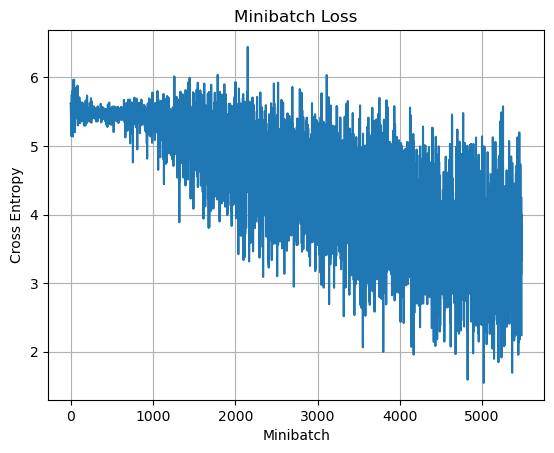

In [ ]:
utils.plot_minibatch_loss(minibatch_loss)

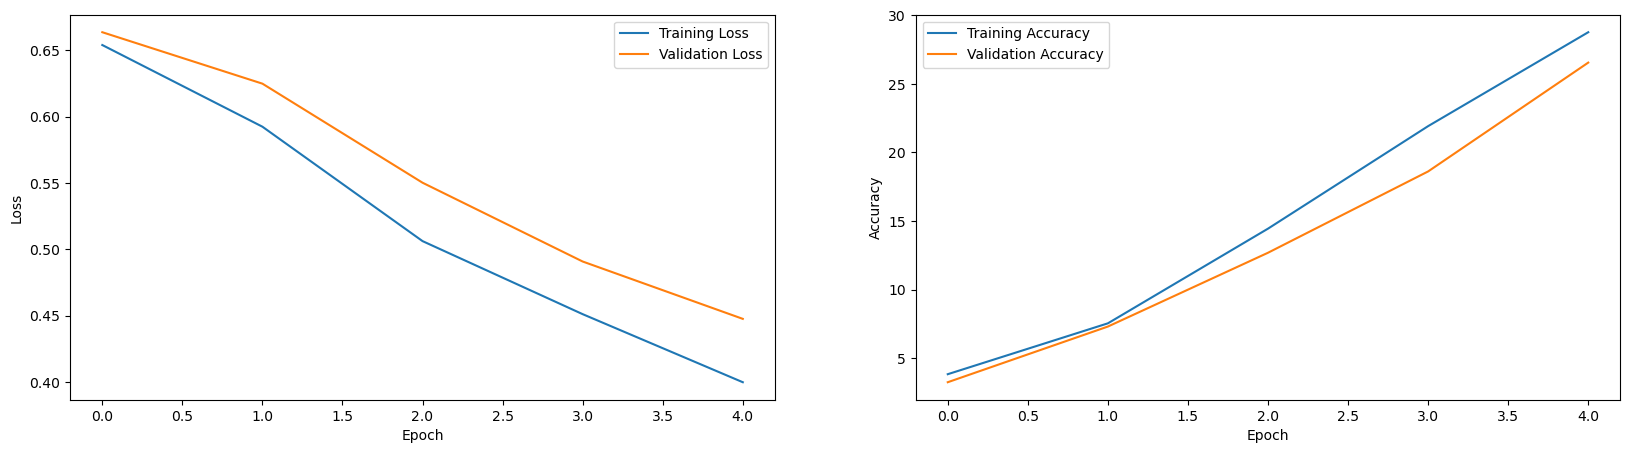

In [ ]:
utils.plot_train_and_valid_loss_and_accuracy(train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst)